In [1]:
import sys
sys.path.append('..')
from pymavlink import mavutil
import matplotlib.pyplot as plt
import pandas as pd
import os
import geopandas as gpd
from shapely.geometry import Point, LineString

from sqlalchemy import create_engine

from config import RUTA_UNIDAD_ONE_DRIVE
from config import RUTA_LOCAL_ONE_DRIVE
from config import POSTGRES_UTEA

RUTA_COMPLETA = os.path.join(RUTA_UNIDAD_ONE_DRIVE, RUTA_LOCAL_ONE_DRIVE)

def obtener_engine():
    return create_engine(
        f"postgresql+psycopg2://{POSTGRES_UTEA['USER']}:{POSTGRES_UTEA['PASSWORD']}@{POSTGRES_UTEA['HOST']}:{POSTGRES_UTEA['PORT']}/{POSTGRES_UTEA['DATABASE']}"
    )

In [31]:
vehiculo = 'DA04'

In [32]:
if vehiculo == 'DA01':
    path_log = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\TLOGS\ALTA_01'
elif vehiculo == 'DA02':
    path_log = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\TLOGS\ALTA_02'
elif vehiculo == 'DA03':
    path_log = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\TLOGS\ALTA_03'
elif vehiculo == 'DA04':
    path_log = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\TLOGS\ALTA_04'
contenido = os.listdir(path_log)
len(contenido)

220

In [33]:
gdf_rec = gpd.read_postgis(
    "SELECT * FROM drones_control_bio.recorridos_lib", 
    obtener_engine(), 
    geom_col='geom'  # columna con la geometría
)

In [34]:
gdf_rec.head()

,id,geom,idd,nombre,vehiculo,num_vert,asignado
0,1,"MULTILINESTRING ((471873.745 8084797.248, 4718...",-1,2025-05-02 08-32-28.tlog,DA02,2517.0,ORIGINAL
1,2,"MULTILINESTRING ((478886.299 8093597.535, 4788...",-1,2025-05-05 16-16-47.tlog,DA02,1056.0,ORIGINAL
2,247,"MULTILINESTRING ((474276.861 8075803.608, 4742...",616,2025-08-12 03-00-11.tlog,DA02,1710.0,None
3,248,"MULTILINESTRING ((473445.600 8076788.235, 4734...",616,2025-08-12 03-45-43.tlog,DA02,1605.0,None
4,249,"MULTILINESTRING ((469649.803 8090516.827, 4696...",617,2025-08-12 04-25-58.tlog,DA02,1988.0,None


In [35]:
# Filtrar la lista 'contenido' para excluir elementos que están en la columna 'nombre' del GeoDataFrame
contenido_filtrado = [item for item in contenido if item not in gdf_rec['nombre'].values]
len(contenido_filtrado)

28

In [36]:
contenido_filtrado

['2026-02-09 23-35-25.tlog',
 '2026-02-10 00-29-05.tlog',
 '2026-02-10 01-34-48.tlog',
 '2026-02-10 02-12-04.tlog',
 '2026-02-10 02-37-29.tlog',
 '2026-02-10 04-11-22.tlog',
 '2026-02-10 05-01-31.tlog',
 '2026-02-10 18-08-10.tlog',
 '2026-02-10 18-36-39.tlog',
 '2026-02-10 19-15-27.tlog',
 '2026-02-10 21-10-06.tlog',
 '2026-02-10 21-57-57.tlog',
 '2026-02-10 22-45-13.tlog',
 '2026-02-10 22-58-35.tlog',
 '2026-02-10 23-21-09.tlog',
 '2026-02-10 23-55-50.tlog',
 '2026-02-10 23-57-52.tlog',
 '2026-02-11 00-38-51.tlog',
 '2026-02-11 01-39-24.tlog',
 '2026-02-11 02-00-37.tlog',
 '2026-02-11 19-01-52.tlog',
 '2026-02-11 21-23-46.tlog',
 '2026-02-11 21-59-28.tlog',
 '2026-02-11 22-50-44.tlog',
 '2026-02-12 00-44-52.tlog',
 '2026-02-12 01-10-45.tlog',
 '2026-02-12 03-23-17.tlog',
 '2026-02-12 03-55-19.tlog']

In [37]:
def leer_logs(lista_logs):
    list_geo = []
    list_name = []
    for i in lista_logs:
        log = path_log + '/' + i
        
        name = i
        print(name)
        
        mlog = mavutil.mavlink_connection(log)
        lats = []
        lons = []
        while True:
            msg = mlog.recv_match()
            if not msg:
                break
            # Ejemplo de procesamiento de mensaje
            if msg.get_type() == 'GLOBAL_POSITION_INT':
                lat = msg.lat / 1e7  # Latitud en grados
                lon = msg.lon / 1e7  # Longitud en grados
                lats.append(lat)
                lons.append(lon)

        coors = {'lat':lats, 'lon':lons}
        df = pd.DataFrame(coors)
        
        geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
        line = LineString(geometry)
        list_geo.append(line)
        list_name.append(name)
    return (list_geo, list_name)

In [38]:
lineas, names = leer_logs(contenido_filtrado)
lineas

2026-02-09 23-35-25.tlog
2026-02-10 00-29-05.tlog
2026-02-10 01-34-48.tlog
2026-02-10 02-12-04.tlog
2026-02-10 02-37-29.tlog
2026-02-10 04-11-22.tlog
2026-02-10 05-01-31.tlog
2026-02-10 18-08-10.tlog
2026-02-10 18-36-39.tlog
2026-02-10 19-15-27.tlog
2026-02-10 21-10-06.tlog
2026-02-10 21-57-57.tlog
2026-02-10 22-45-13.tlog
2026-02-10 22-58-35.tlog
2026-02-10 23-21-09.tlog
2026-02-10 23-55-50.tlog
2026-02-10 23-57-52.tlog
2026-02-11 00-38-51.tlog
2026-02-11 01-39-24.tlog
2026-02-11 02-00-37.tlog
2026-02-11 19-01-52.tlog
2026-02-11 21-23-46.tlog
2026-02-11 21-59-28.tlog
2026-02-11 22-50-44.tlog
2026-02-12 00-44-52.tlog
2026-02-12 01-10-45.tlog
2026-02-12 03-23-17.tlog
2026-02-12 03-55-19.tlog


[<LINESTRING (0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0...>,
 <LINESTRING (-63.193 -17.383, -63.193 -17.383, -63.193 -17.383, -63.193 -17....>,
 <LINESTRING (0 0, 0 0, -63.185 -17.375, -63.185 -17.375, -63.185 -17.375, -6...>,
 <LINESTRING (0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, -63.179 -17.371, -...>,
 <LINESTRING (0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, -63.197 -17.373, -...>,
 <LINESTRING (0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0...>,
 <LINESTRING (0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0...>,
 <LINESTRING (0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0...>,
 <LINESTRING (0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, -63.391 -17.337, -...>,
 <LINESTRING (0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, -63.366 -17.318, -...>,
 <LINESTRING (0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0...>,
 <LINESTRING (0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, -63.34 -17.108, -6...>,
 <LI

In [39]:
# Crear un GeoDataFrame con los LineStrings y sus nombres
gdf_lines = gpd.GeoDataFrame({'nombre': names, 'geometry': lineas}, crs="EPSG:4326")
gdf_lines.head(3)

,nombre,geometry
0,2026-02-09 23-35-25.tlog,"LINESTRING (0.00000 0.00000, 0.00000 0.00000, ..."
1,2026-02-10 00-29-05.tlog,"LINESTRING (-63.19311 -17.38309, -63.19311 -17..."
2,2026-02-10 01-34-48.tlog,"LINESTRING (0.00000 0.00000, 0.00000 0.00000, ..."


In [40]:
# Función para contar la cantidad de coordenadas en una geometría de tipo LINESTRING
def contar_coordenadas(linea):
    return len(linea.coords)

# Función para dividir y limpiar las líneas
def dividir_y_limpiar_linea(linea):
    puntos = list(linea.coords)
    nuevas_lineas = []
    nueva_linea = []
    
    for punto in puntos:
        if punto != (0, 0):
            nueva_linea.append(punto)
        else:
            if nueva_linea:
                nuevas_lineas.append(LineString(nueva_linea))
                nueva_linea = []
    
    if nueva_linea:
        nuevas_lineas.append(LineString(nueva_linea))
    
    return nuevas_lineas

In [41]:
# Crear una lista para las nuevas líneas y nombres
nuevas_lineas = []
nuevos_nombres = []
for idx, row in gdf_lines.iterrows():
    lineas_divididas = dividir_y_limpiar_linea(row.geometry)
    for linea in lineas_divididas:
        nuevas_lineas.append(linea)
        nuevos_nombres.append(row['nombre'])

In [42]:
# Crear un nuevo GeoDataFrame con las nuevas líneas
gdf_lines = gpd.GeoDataFrame({'nombre': nuevos_nombres, 'geometry': nuevas_lineas}, crs="EPSG:4326")

In [43]:
gdf_lines['num_vert'] = gdf_lines['geometry'].apply(contar_coordenadas)
gdf_lines['vehiculo'] = vehiculo
gdf_lines.head(3)

,nombre,geometry,num_vert,vehiculo
0,2026-02-09 23-35-25.tlog,"LINESTRING (-63.22432 -17.39345, -63.22438 -17...",2281,DA04
1,2026-02-10 00-29-05.tlog,"LINESTRING (-63.19311 -17.38309, -63.19311 -17...",3307,DA04
2,2026-02-10 01-34-48.tlog,"LINESTRING (-63.18515 -17.37484, -63.18515 -17...",4874,DA04


<Axes: >

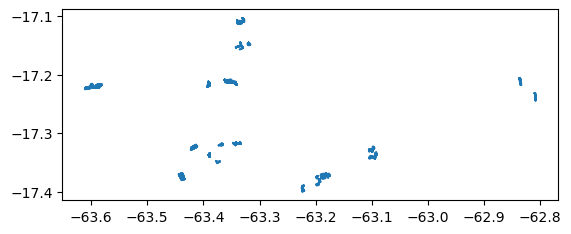

In [44]:
gdf_lines.plot()

In [45]:
gdf_lines.crs = "EPSG:4326"
gdf_lines_utm = gdf_lines.to_crs(epsg=32720)

<Axes: >

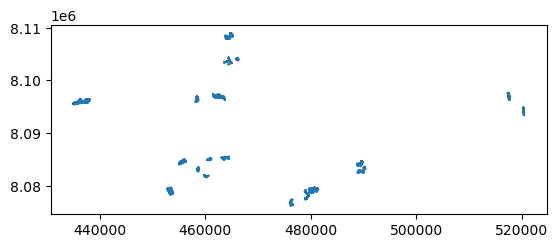

In [46]:
gdf_lines_utm.plot()

In [47]:
gdf_lines_utm['idd'] = 0
gdf_lines_utm = gdf_lines_utm.rename_geometry("geom")

In [48]:
gdf_lines_utm

,nombre,geom,num_vert,vehiculo,idd
0,2026-02-09 23-35-25.tlog,"LINESTRING (476173.283 8076904.819, 476166.940...",2281,DA04,0
1,2026-02-10 00-29-05.tlog,"LINESTRING (479486.742 8078053.977, 479486.742...",3307,DA04,0
2,2026-02-10 01-34-48.tlog,"LINESTRING (480331.858 8078968.512, 480331.719...",4874,DA04,0
3,2026-02-10 01-34-48.tlog,"LINESTRING (480333.740 8078966.335, 480333.730...",2442,DA04,0
4,2026-02-10 02-12-04.tlog,"LINESTRING (480937.757 8079393.508, 480937.694...",2064,DA04,0
5,2026-02-10 02-37-29.tlog,"LINESTRING (479085.992 8079155.608, 479085.992...",661,DA04,0
6,2026-02-10 04-11-22.tlog,"LINESTRING (490083.745 8082831.930, 490083.108...",3649,DA04,0
7,2026-02-10 04-11-22.tlog,"LINESTRING (490077.039 8082835.666, 490077.061...",2392,DA04,0
8,2026-02-10 05-01-31.tlog,"LINESTRING (489408.212 8084242.883, 489408.797...",3840,DA04,0
9,2026-02-10 18-08-10.tlog,"LINESTRING (463950.194 8085350.556, 463950.194...",3567,DA04,0


In [49]:
gdf_lines_utm.to_postgis(
    name="recorridos_lib",
    schema="drones_control_bio",
    con=obtener_engine(),
    if_exists="append",   # usa "replace" si quieres sobrescribir todo
    index=False
)